In [1]:
# imports

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import pandas as pd
import random
import seaborn as sns
import pymc3 as pm
import time
from pymc3.distributions.dist_math import normal_lcdf, normal_lccdf
import theano.tensor as tt

%matplotlib inline

# Simulating data

## Population

In [2]:
# Simulate a sample of 2000
n = 2000

In [3]:
# SEPARATIONS (AU)

# modeled as a gaussian of log(separation)
# these parameters based on arxiv.org/abs/1901.06364
# distribution to match st.norm.pdf(np.log(sepatations), np.log(10), np.log(3)) - a peak at 10AU
# these are the mean and standard deviation of the underlying normal distribution
mean = 3.5
sigma = 1

sep_physical = np.random.lognormal(mean=mean, sigma=sigma, size=n)

In [4]:
# INVERTED MASS RATIOS and MASS RATIOS

# Modeled as a Pareto distribution
# Define Pareto shape (a) and scale/minimum (m)
a = 1.2
m = 1

mass_ratios_inverted = (np.random.pareto(a, size=n) + 1)*m
mass_ratios = 1/mass_ratios_inverted

In [5]:
# DISTANCES (PARSECS)
# Limiting to 100 pc around us, the distances should follow a power law with index 2, as n increases with r^2
#dist_physical  = np.random.power(3, size=n)*150               # in parsecs
dist_physical  = np.random.beta(2, 4, size=n)*200               # in parsecs

# PARALLAX
dist_parallax = 1/dist_physical

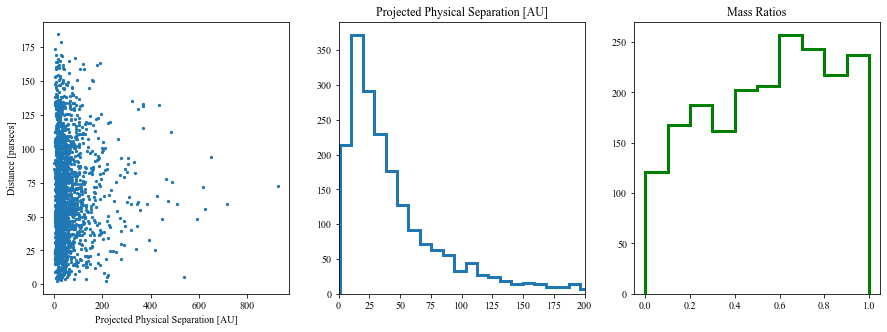

In [6]:
# Look at the distributions of the physical parameters of the systems
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(sep_physical, dist_physical, s=5)
plt.xlabel('Projected Physical Separation [AU]')
plt.ylabel('Distance [parsecs]')

plt.subplot(132)
plt.hist(sep_physical, bins=100, histtype='step', linewidth=3)
plt.xlim(0, 200)
plt.title('Projected Physical Separation [AU]');

plt.subplot(133)
plt.title('Mass Ratios')
plt.hist(mass_ratios, histtype='step', color='g', linewidth=3);

In [7]:
# saving original population 
original_population = pd.DataFrame(np.transpose(np.array([sep_physical, dist_physical, mass_ratios])), 
                            columns = ['sep_physical', 'dist_physical', 'mass_ratio'])

## Observatbles

**Separations:**

$\text{parallax }["] =\frac{1}{\text{distance }[pc] }$

$\text{angular separation }["] = \big(\text{physical separation }[AU]\big)\ \  x\ \ \big(\text{parallax }["]\big)$


**Contrast Ratios:**

From section 4.4 of (Lamman et al), we have an emperical relationship between the inverse mass ratio ($\frac{1}{R_m}$) and inverse Robo-AO contrast ratio ($\frac{1}{R_c}$), given by a 4th degree polynomial:

$1/R_c = 20.3 - 63.1(1/R_m) + 72.5(1/R_m)^2 -40.4(1/R_m)^3  +10.6(1/R_m)^4$

In [8]:
# from inverse mass ratios to inverse contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_icr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return 1 / g(1/x)

In [9]:
# TRANSFORM PHYSICAL SEPARATIONS TO ANGULAR SEPARATIONS
sep_angular = sep_physical / dist_physical

# TRANSFORM INVERSE MASS RATIOS TO INVERSE CONTRAST RATIOS
contrast_ratios_inverted = imr_to_icr(mass_ratios_inverted)
contrast_ratios = 1/contrast_ratios_inverted

## Measurements

Robo-AO Errors for all angular separations $\approx 0.07"$

Gaia parallax errors $\approx 0.005$ (Max is $\sim 0.015$, but will ignore parallax errors for now)

Here I'll just use a rought estimate of typical Robo-AO contrast errors. I'll model it as mostly random but higher for systems at close separations.

In [10]:
# ADD ERRORS FOR MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS

# Separations
sep_ang_e = 0.07

# Contrasts
cr_err = np.random.random_sample((len(contrast_ratios),))/10
cr_err = (cr_err/(sep_angular))*np.random.random()

In [11]:
# SAMPLE THE MEASURED SEPARATIONS AND MEASURED CONTRAST RATIOS FROM GAUSSIANS AROUND THE OBSERVABLE SEPs AND CRs

sep_measured = np.random.normal(loc=sep_angular, scale=sep_ang_e)

# contrast ratios are, by definition > 0 
cr_measured = np.abs(np.random.normal(loc=contrast_ratios, scale = cr_err))

## Catalog

**MAPPING**
 
Robo-AO will generally only detect a companion if:

1. $(\text{angular separation})\  < 4.0"$   (Survey only looked within $4"$, 0.1" is )


2. $(\text{Robo-AO contrast})\  < 1.8\ \ln{(\text{angular separation ["])}} + 3.8$<br>
_This is a ROUGH model of a typical Robo-AO contrast curve, and should be improved in the future by creating a model based on the average contrast curve of each observation in the survey, or take into account individual contrast curves._

In [12]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
sep_ang_max = 4.0

# limit for contrast ratio
# this is a rough approximation made by eye - should eventually be updated
def cr_max(separation):
    return 1.8 * np.log(separation) + 3.8

In [13]:
measurements = pd.DataFrame({'asep':sep_measured,'asep_err':[sep_ang_e]*len(sep_angular),
                                 'cr':cr_measured, 'cr_err':cr_err,
                                 'parallax':dist_parallax})

# Apply the observational limitations to get our synthetic catalog
catalog = measurements.loc[(measurements['asep']<sep_ang_max) &
                           (measurements['cr']<cr_max(measurements['asep']))]


# contrast ratios are, by defition, positive, so will take the absolute value here
##catalog = catalog.abs();

"Recreating" Fig 6 in the original survey paper<br>
(https://arxiv.org/pdf/2001.05988.pdf)

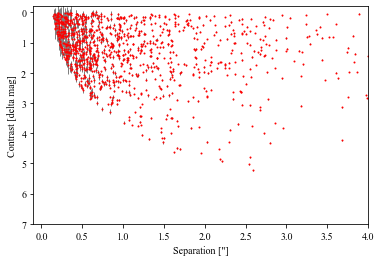

In [14]:
plt.errorbar(catalog['asep'], catalog['cr'], yerr=catalog['cr_err'], 
             marker='.', mec='r', ms=2, ls='none', linewidth=1, ecolor='grey')
plt.ylim(7, -0.2); plt.xlim(-0.1, 4)
plt.xlabel('Separation ["]'); plt.ylabel('Contrast [delta mag]');

# Modeling and Fitting Simulated Data

In [15]:
data = catalog
op = original_population

In [16]:
# LIMITS FOR WHAT WILL APPEAR IN THE FINAL DATA

# limits for separations
sep_ang_max = 4.0


# limit for high contrast ratio and low separations
# this is a rough approximation made by eye - should eventually be updated
def icr_max(separation):
    '''returns the inverse of the maximum contrast ratio which can be detected at a given separations'''
    return 1 / (1.8 * np.log(separation) + 3.8)

def sep_min(icr):
    '''returns the maxmimum separation that can be detected for a given inverse contrast ratio'''
    cr = 1/icr
    return np.exp((cr-3.8)/1.8)

# from inverse mass ratios to inverse contrast ratios
# this is an empirical relationship based on the results from (Lamman et al.) Section 4.4
def imr_to_icr(x):
    g = np.poly1d([ 20.34258759, -63.07636188,  72.52402942, -40.42916102, 10.64895881])
    return 1 / g(1/x)

In [17]:
def pymc3_hrchl_fit(data, nsteps=1000):
    asep = data['asep'].values
    asep_err = data['asep_err'].values
    cr = data['cr'].values
    cr_err = data['cr_err'].values
    parallax = data['parallax'].values
    #mass_ratio_data = data['mass_ratios'].values
    #psep_data = data['psep'].values

    cr_inverse = 1/cr
    cr_err_inverse = 1/cr_err # cr_err/cr
    
    with pm.Model() as hierarchical_model:

        # PRIORS
        # -------------
        
        # Separations
        width = pm.Gamma('width', mu=1.1, sigma=0.5)
        center = pm.Gamma('center', mu=5, sigma=3)
        
        
        # power_index 
        power_index = pm.Normal('power_index', mu=1.2, sigma=.2)
        
        
        # MODELS OF POPULATIONS PHYSICAL PROPERTIES
        # --------------
        
        # Gaussian model for separations (in AU)
        sep_physical = pm.Lognormal('sep_physical', mu=center, sigma=width)
        
        # Mass Ratios - inverted
        mass_ratios_inverted = pm.Pareto('mass_ratios_inverted', alpha=power_index, m=1)#, shape=len(cr_inverse))
        
        
        # MAPPING FROM PHYSICAL TO OBSERVED PROPERTIES
        # ---------------

        #  physical separations to angular separations
        sep_angular = pm.Deterministic('sep_angular', sep_physical * parallax)
        
        # inverted mass ratios to inverted contrast ratios
        contrast_ratios_inverted = pm.Deterministic('contrast_ratios_inverted', imr_to_icr(mass_ratios_inverted))
        
        
        
        # LIKELIHOODS, WITH MEASUREMENT ERROR
        # -----------------
        
        # separations
        sep_observed = pm.Normal('sep_observed', mu=sep_angular, sigma=asep_err, observed=asep)
        
        # contrast ratios
        cr_observed_inverse = pm.Normal('cr_observed', mu=contrast_ratios_inverted, sigma=cr_err_inverse, observed=cr_inverse)
        
        
        # ACCOUNTING FOR OBSERVATION LIMITS
        # ------------------
        
        # integrate out the points which fall outside of the observation limits from the likelihood
        # pm.Potential accounts for truncation and normalizes likelihood
        
        # separation limits
        truncated_seps_upper = pm.Potential('upper_truncated_seps', normal_lccdf(sep_observed, asep_err, sep_ang_max))
        truncated_seps_lower = pm.Potential('lower_truncated_seps', normal_lcdf(sep_observed, asep_err, sep_min(cr_observed_inverse)))
        
        # contrast ratio limits - function of separations
        truncated_crs = pm.Potential('crs_truncated', normal_lccdf(cr_observed_inverse, cr_err_inverse, icr_max(sep_observed)))

        
        
        # RUNNING THE FIT
        # -------------------
        traces = pm.sample(tune=nsteps, draws=nsteps, step=None, chains=1)
        
        # output as dataframe
        df = pm.trace_to_dataframe(traces)
    return df

In [ ]:
ta = time.time()
samples = pymc3_hrchl_fit(data, nsteps=1000)
tb = time.time()
print('Fit finished, took ',round((tb -ta)/60., 1),' minutes' )

C:\Users\Claire\Anaconda3\lib\site-packages\pymc3\distributions\continuous.py:88: UserWarning: The variable specified for alpha has negative support for Pareto, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [ ]:
# estimate of the MAP
q = samples.quantile([0.16,0.50,0.84], axis=0)
c_lower, c, c_upper = q['center']
w_lower, w, w_upper = q['width']

p_lower, p, p_upper = q['power_index']

In [ ]:
sns.distplot(samples[samples.columns[3:1130]].quantile(0.5))

## Comparing Results to Original Population

In [ ]:
# functions to plot
import scipy.stats as st
    
def plot_power_law(index, data, bins, label):
    xs = np.linspace(0, np.max(data), 100)
    ys = index*xs**(index-1.)
    normed_y = len(data)*np.diff(bins)[0]*ys
    plt.plot(xs, normed_y, label=label);
    
def plot_lognorm(mu, sigma, data, bins, label):
    xs = np.linspace(0, np.max(data), 1000)
    pdfn = st.lognorm.pdf(xs, sigma, scale=np.exp(mu))
    normedy = len(data)*np.diff(bins)[0]*pdfn
    plt.plot(xs, normedy, label=label)

In [ ]:
# testing against distributions used to make simulated data

fig = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Physical Separations [AU]')
count, bns, ignored = plt.hist(op['sep_physical'], histtype='step', label='simulated data', bins=100, linewidth=1)
plot_lognorm(3.5, 1, op['sep_physical'], bns, 'original distribution')
plot_lognorm(c, w, op['sep_physical'], bns, 'fit')
plt.xlim(0, 100)
plt.legend();
print("center = {:.2f} + {:.2f} - {:.2f}".format(c, c_upper-c, c-c_lower))
print("width = {:.1f} + {:.1f} - {:.1f}".format(w, w_upper-w, w-w_lower))

plt.subplot(122)
plt.title('Mass Ratios')
count, bns, ignored = plt.hist(op['mass_ratio'], histtype='step', label='simulated data', bins=10, linewidth=2)
plot_power_law(1.2, op['mass_ratio'], bns, 'original distribution')
plot_power_law(p, op['mass_ratio'], bns, 'fit')
plt.legend(loc='lower right');
print("\npower index = {:.2f} + {:.2f} - {:.2f}".format(p, p_upper-p, p-p_lower))


#fig.savefig('model_fit6.png', dpi=200)